Load SQL database into a dataframe

In [1]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.close('all')

sqlite_file = 'lahman2014.sqlite'
conn = sq.connect(sqlite_file)

salary_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries WHERE lgID == 'AL' GROUP BY yearID"
team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()

,yearID,total_payroll
0,1985,134401120.0
1,1986,157716444.0
2,1987,136088747.0
3,1988,157049812.0
4,1989,188771688.0


Problem 1

Now we collect usefull stats on each team from each year (wins, games played, win percentage, and payroll). We need to compute win percentage and payroll per team per year. The payroll is joined on the year and team IDs. Payroll info is missing in lots of the teams data, but since we're primarily interested in payroll, we drop rows which are missing values, hence the inner join.

In [2]:
def wp_calc(W,G):
        return W/G*100

# store easy values in out win percentage frame
df_query = "SELECT yearID, teamID, W, G FROM Teams"

# calculate win percentage
df = pd.read_sql(df_query, conn)
df.dropna(axis = 'index', inplace = True)
df["W_P"] = wp_calc(df["W"],df["G"])

# calculate payroll for each team for each year and merge it into wp
payroll_query = "SELECT yearID, teamID, sum(salary) as payroll FROM Salaries GROUP BY yearID, teamID"
payroll = pd.read_sql(payroll_query, conn)
df = pd.merge(df, payroll, how = 'inner', left_on = ['yearID','teamID'], right_on = ['yearID','teamID'])

df

,yearID,teamID,W,G,W_P,payroll
0,1985,BAL,83,161,51.552795,11560712.0
1,1985,BOS,81,163,49.693252,10897560.0
2,1985,CAL,90,162,55.555556,14427894.0
3,1985,CHA,85,163,52.147239,9846178.0
4,1985,CLE,60,162,37.037037,6551666.0
...,...,...,...,...,...,...
853,2014,PIT,88,162,54.320988,77178000.0
854,2014,SDN,77,162,47.530864,75685700.0
855,2014,SFN,88,162,54.320988,20000000.0
856,2014,SLN,90,162,55.555556,120693000.0


Payroll Distribution

Problem 2:
Here we plot mean payroll (averaged across all teams) and standard deviation. The max and min payrolls are also plotted for context.

Question 1:
We observe that payrolls tend to increase over time, as does the gap between min and max payrolls. The data appears to be skewed to the right

Problem 3: See the plots below. They both illustrate mostly the same information, but the bottom has been cleaned up and simplified to better illstrate the claims made in Q1.

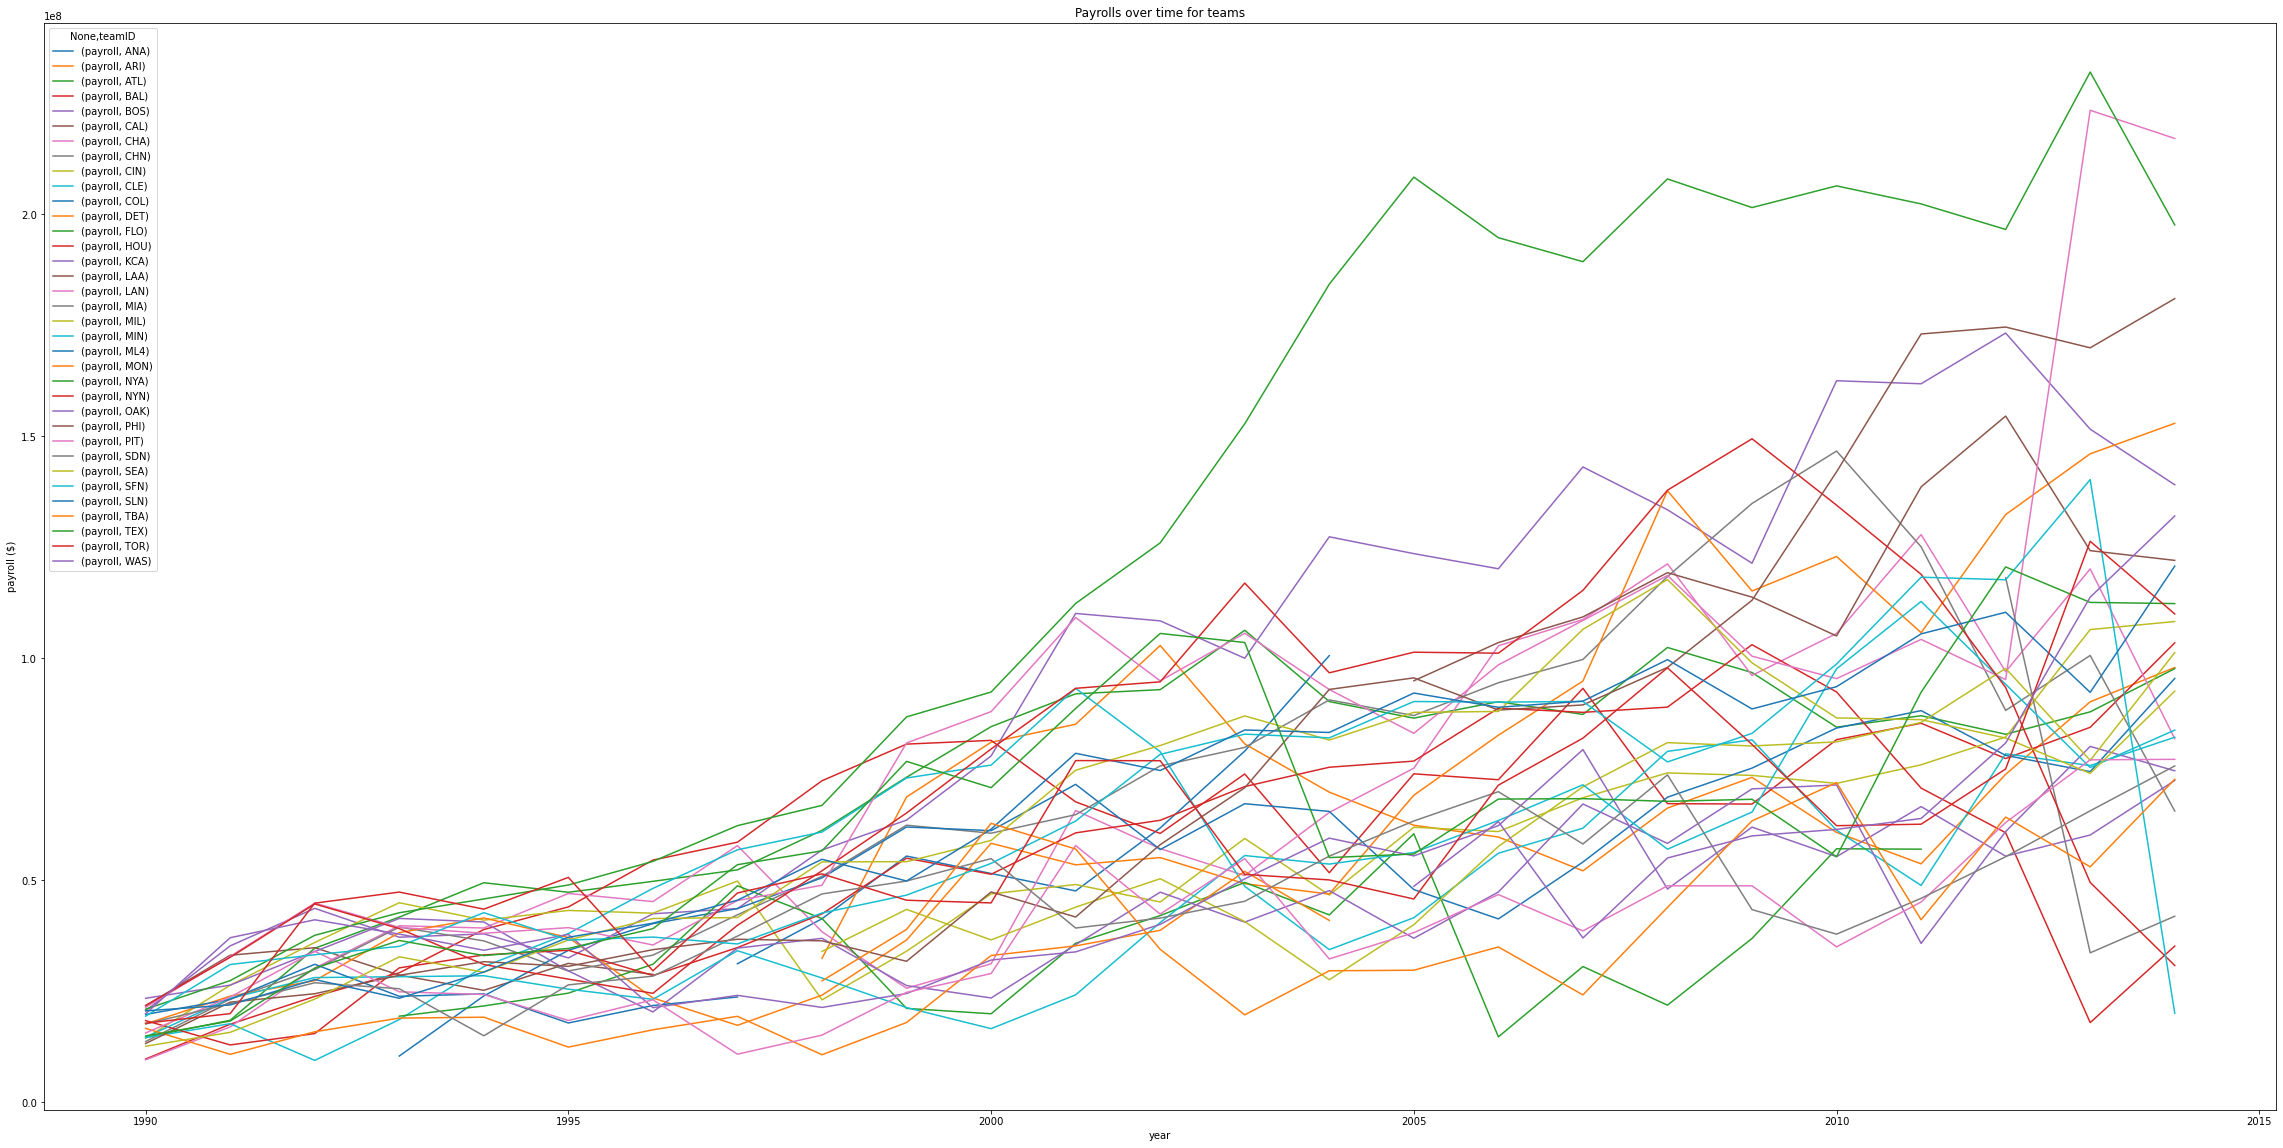

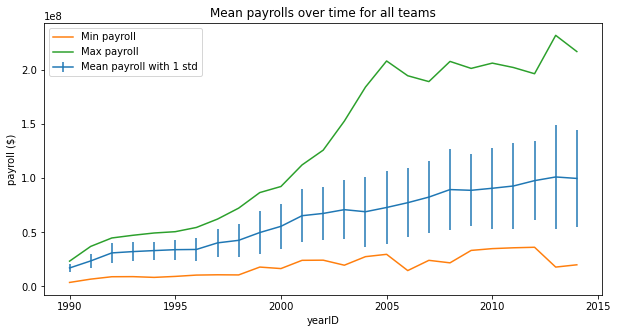

In [3]:
payroll = df[df.yearID >= 1990]
win_percentage = payroll
payroll = payroll.pivot_table(index = ['yearID'], columns = ['teamID'], values = ['payroll'])
win_percentage = win_percentage.pivot_table(index = ['yearID'], columns = ['teamID'], values = ['W_P'])

ax1 = payroll.plot(figsize=(40,20), title = "Payrolls over time for teams", xlabel = "year", ylabel = "payroll ($)")

payroll["mean_payroll"] = payroll[payroll.columns].mean(axis = 1)
payroll["std_dev_payroll"] = payroll[payroll.columns].std(axis = 1)
payroll["min_payroll"] = payroll[payroll.columns].min(axis = 1)
payroll["max_payroll"] = payroll[payroll.columns].max(axis = 1)

win_percentage["mean_win_percentage"] = win_percentage.mean(axis = 1)

ax2 = payroll.plot(y = "mean_payroll", figsize=(10,5), title = "Mean payrolls over time for all teams", xlabel = "year", ylabel = "payroll ($)", yerr = payroll["std_dev_payroll"])
ax2 = payroll.plot(y = ["min_payroll","max_payroll"], ax = ax2)
ax2.legend(['Min payroll','Max payroll','Mean payroll with 1 std'])

Correlation Between Payroll and Winning Percentage

Problem 4: We plot the mean winning percentage of each team against their payroll for each of the 5 time intervals.


Question 2: Oakland and Cincinnati both stand out as teams which tend to have high win percentages to their payroll. We are also able to see that CHN tends to spend money poorly, where the spend more and win less than the average team.

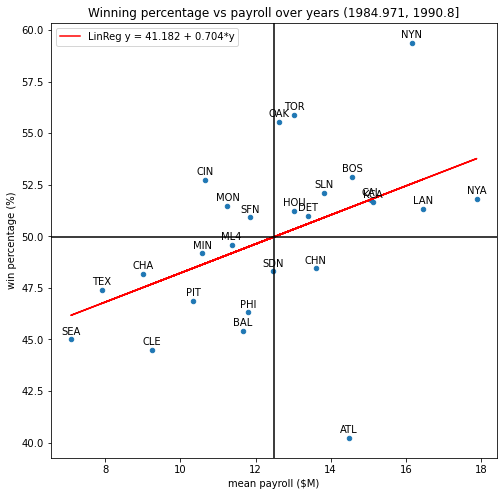

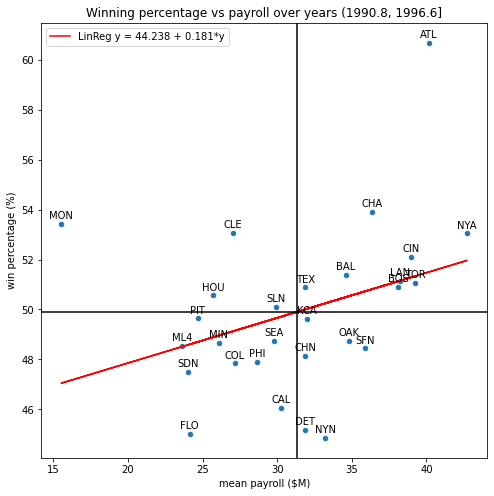

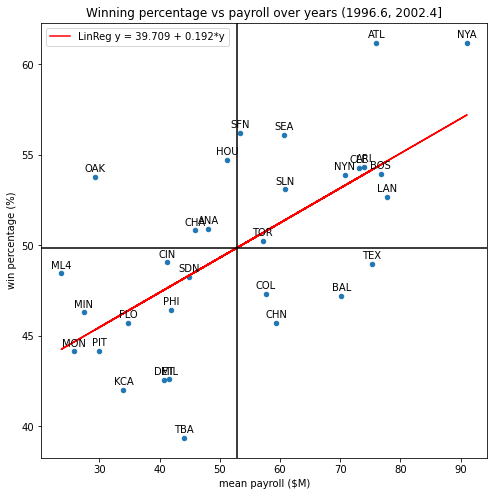

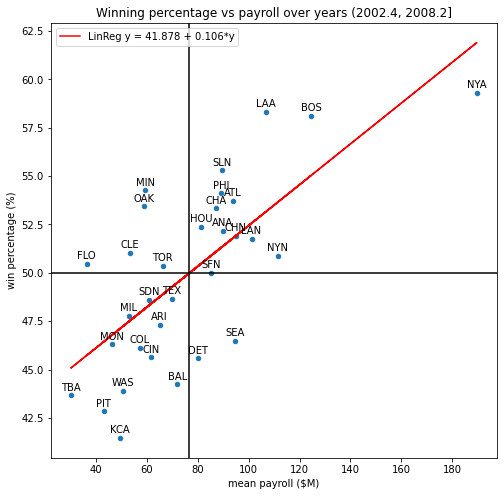

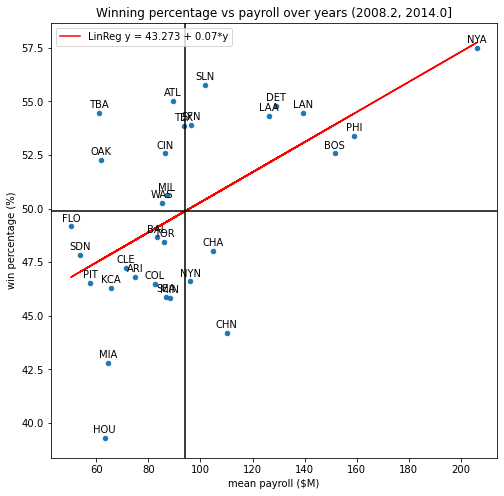

In [4]:
df['bin'] = pd.cut(df.yearID, bins = 5)
bins = pd.unique(df.bin)
for bin in bins:
    interval_data = df.loc[df['bin'] == bin]
    mean_interval_data = interval_data.groupby('teamID').mean()
    mean_interval_data['payroll_M'] = mean_interval_data['payroll'].divide(10**6)
    x = mean_interval_data['payroll_M']
    y = mean_interval_data['W_P']
    ax = mean_interval_data.plot.scatter(x = 'payroll_M', y = 'W_P', figsize=(8,8))
    ax.set_xlabel('mean payroll ($M)')
    ax.set_ylabel('win percentage (%)')
    m, b = np.polyfit(x,y,1)
    plt.plot(x,m*x+b,c='r',label = f'LinReg y = {round(b,3)} + {round(m,3)}*y')
    plt.legend(loc = 'upper left')
    plt.axhline(mean_interval_data.W_P.mean(),color='black')
    plt.axvline(mean_interval_data.payroll_M.mean(),color='black')
    ax.set_title(f'Winning percentage vs payroll over years {bin}')
    for index, data in mean_interval_data.iterrows():
        label = data.name
        x = data.payroll_M
        y = data.W_P
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,5), ha='center')

Correlation Between Payroll and Winning Percentage

Problem 5/6: We plot the win percentage of teams against their standardized payroll


Question 3: We can now compare how many standard deviations away from the average spending a team is. This makes the efficiency of spending easier to compare. The data has also been standardized across the year.

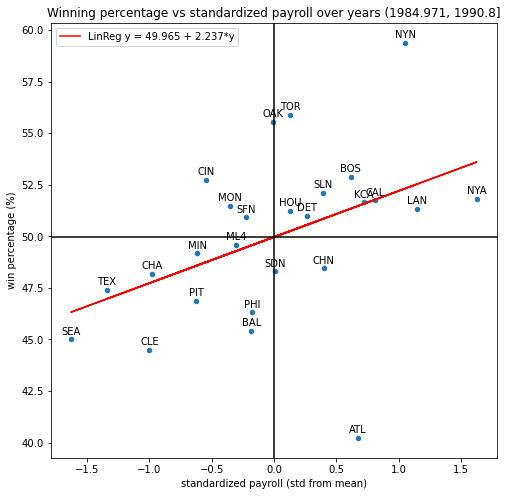

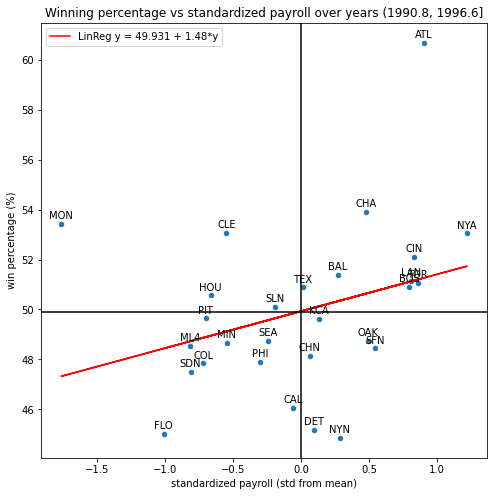

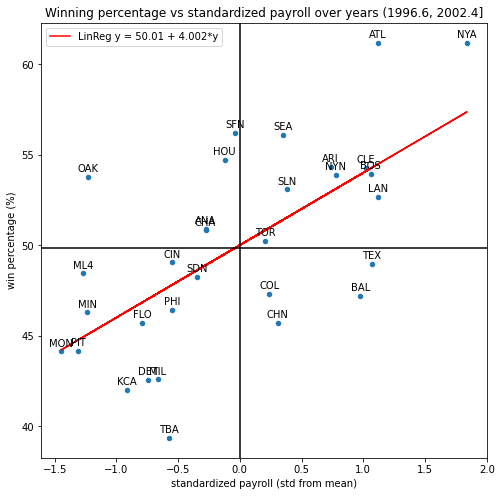

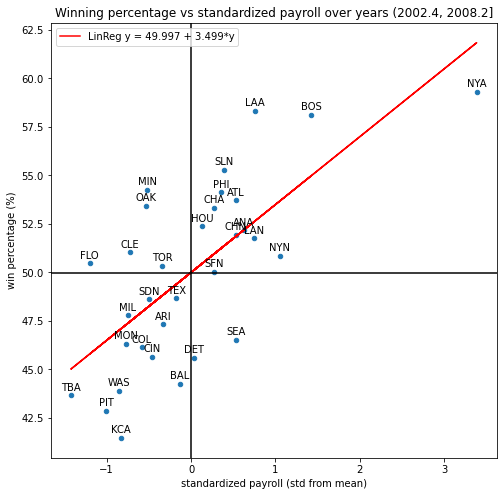

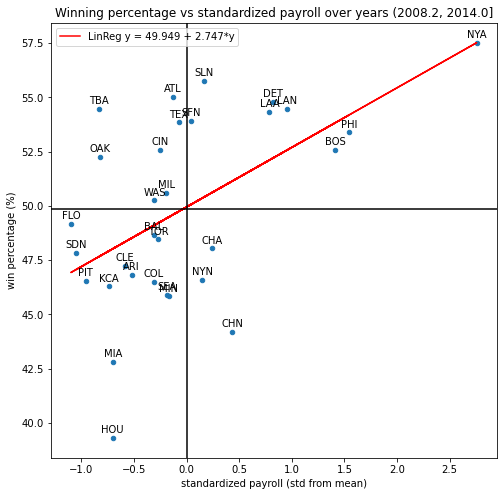

In [5]:
df['bin'] = pd.cut(df.yearID, bins = 5)
bins = pd.unique(df.bin)
year_data = pd.DataFrame(columns = ['mean_payroll_year','std_payroll_year'])
for year in df.yearID.unique() :
    rows = df.loc[df['yearID'] == year]
    year_data.loc[year] = [rows.payroll.mean(),rows.payroll.std()]
df = df.merge(year_data,how = 'right',left_on = 'yearID', right_index = True)
df['standardized_payroll'] = (df['payroll']-df['mean_payroll_year'])/df['std_payroll_year']

for bin in bins:
    interval_data = df.loc[df['bin'] == bin]
    mean_interval_data = interval_data.groupby('teamID').mean()
    x = mean_interval_data['standardized_payroll']
    y = mean_interval_data['W_P']
    ax = mean_interval_data.plot.scatter(x = 'standardized_payroll', y = 'W_P', figsize=(8,8))
    ax.set_xlabel('standardized payroll (std from mean)')
    ax.set_ylabel('win percentage (%)')
    m, b = np.polyfit(x,y,1)
    plt.plot(x,m*x+b,c='r',label = f'LinReg y = {round(b,3)} + {round(m,3)}*y')
    plt.legend(loc = 'upper left')
    plt.axhline(mean_interval_data.W_P.mean(),color='black')
    plt.axvline(0,color='black')
    ax.set_title(f'Winning percentage vs standardized payroll over years {bin}')
    for index, data in mean_interval_data.iterrows():
        label = data.name
        x = data.standardized_payroll
        y = data.W_P
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,5), ha='center')

Expected Wins

Problem 7: We plot win percentage vs standardized payroll.

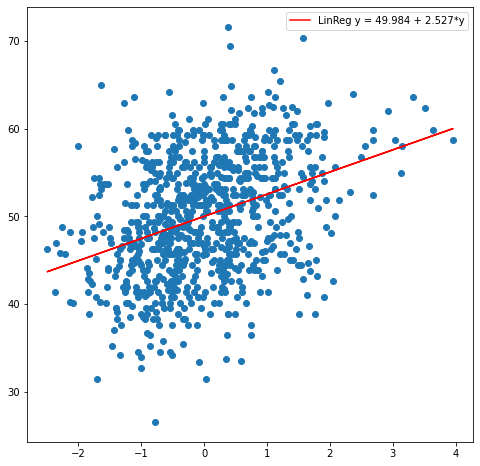

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
x = df.standardized_payroll
y = df.W_P
ax.scatter(x,y)
m, b = np.polyfit(x,y,1)
ax.plot(x,b+m*x, c = 'r', label = f'LinReg y = {round(b,3)} + {round(m,3)}*y')
ax.legend(loc = 'upper right')

Spending Efficiency

Problem 8: Efficiency is calculated by comparing the actual win percentage of each team with the expected win percentage. We then plot some teams' efficiency over time.

Question 4: It is clear to see the jump in spending efficency during the period that Paul DePodesta joined OAK (he triples their efficiency to make them the best spending team out of all the teams examined). Their efficiency peaks at an impressive 16.41%.

OAK max efficiency: 16.41%


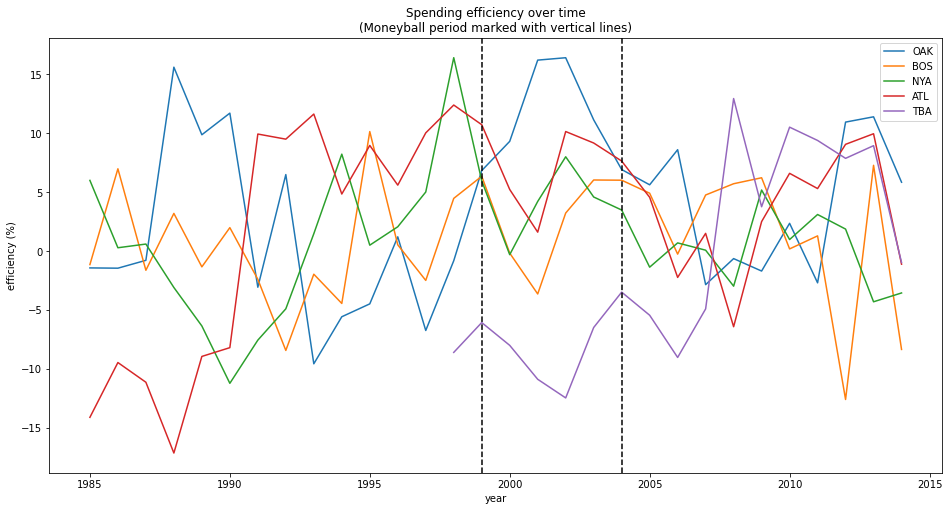

In [39]:
df['efficiency'] = df['W_P']-(b+df['standardized_payroll'].multiply(other = m))
fig, ax = plt.subplots(figsize = (16,8))
teams = ['OAK','BOS','NYA','ATL','TBA']
for team in teams :
    team_data = df.loc[df['teamID'] == team]
    x = team_data.yearID
    y = team_data.efficiency
    ax.plot(x,y,label = team)
ax.legend()
ax.set_title('Spending efficiency over time\n(Moneyball period marked with vertical lines)')
ax.axvline(1999, c = 'k', linestyle = '--')
ax.axvline(2004, c = 'k', linestyle = '--')
ax.set_xlabel('year')
ax.set_ylabel('efficiency (%)')
max_eff_OAK = (df.loc[df['teamID'] == 'OAK']).efficiency.max()
print(f'OAK max efficiency: {round(max_eff_OAK,2)}%')